In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,CuDNNLSTM
from tensorflow import keras
import string

In [17]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [18]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [19]:
import re
!pip install contractions
import contractions


i=0
for doc in train.comment_text:
    doc = doc.lower()
    doc=  re.sub(r"https?://\S+|www\.\S+",'', doc)  #Remove URLs from a sample string
    doc = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', doc) # clean url
    doc = re.sub(r'#(\w+)', '',doc)   # clean hashes
    doc = re.sub(r'[^\x00-\x7f]',r'', doc) #Remove non-ASCII characters 
    doc = re.sub(r'@(\w+)', '', doc)   # clean @
    doc = re.sub(r'<[^>]+>', '',doc)  # clean tags
    doc = re.sub(r'\d+', '',doc)      # clean digits
    doc=re.sub(r'<.*?>','',doc)
    doc = re.sub("#", " ",doc)
    doc = re.sub(":::", " ", doc)
    doc = re.sub("\n", " ",doc)
    doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
    punctuation = set(string.punctuation)  #remove the punctuation
    doc = "".join([p for p in doc if p not in punctuation])
    doc=contractions.fix(doc)
    train.comment_text[i]=doc
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [40]:
x=train["comment_text"]
y=train["Toxic"]

In [41]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=3,shuffle=True)

In [42]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [43]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(hub_layer)
bi_model.add(tf.keras.layers.Reshape((1,128)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64))) #lstm with 64 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_7 (Reshape)         (None, 1, 128)            0         
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           99328     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              99328     
 nal)                                                 

In [44]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = bi_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 124ms/step - loss: 0.2681 - accuracy: 0.8866 - val_loss: 0.2223 - val_accuracy: 0.9096
Epoch 2/20
462/462 [==============================] - 56s 121ms/step - loss: 0.1305 - accuracy: 0.9507 - val_loss: 0.2763 - val_accuracy: 0.9010
Epoch 3/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0770 - accuracy: 0.9687 - val_loss: 0.3012 - val_accuracy: 0.8986
Epoch 4/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0540 - accuracy: 0.9784 - val_loss: 0.4217 - val_accuracy: 0.8986
Epoch 5/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0393 - accuracy: 0.9848 - val_loss: 0.4546 - val_accuracy: 0.8952
Epoch 6/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0322 - accuracy: 0.9874 - val_loss: 0.4658 - val_accuracy: 0.8965
Epoch 00006: early stopping


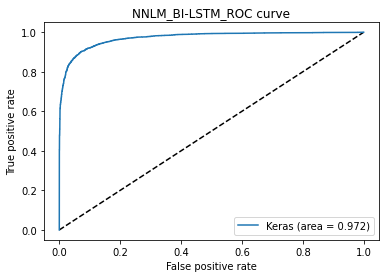

In [45]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_BI-LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [46]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.51362383
              precision    recall  f1-score   support

           0     0.9060    0.9285    0.9171      4154
           1     0.9248    0.9013    0.9129      4054

    accuracy                         0.9151      8208
   macro avg     0.9154    0.9149    0.9150      8208
weighted avg     0.9153    0.9151    0.9151      8208



In [47]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_8 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,161
Trainable params: 124,692,161
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 57s 120ms/step - loss: 0.1670 - accuracy: 0.9397 - val_loss: 0.2582 - val_accuracy: 0.9029
Epoch 2/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0818 - accuracy: 0.9690 - val_loss: 0.3195 - val_accuracy: 0.8971
Epoch 3/20
462/462 [==============================] - 55s 118ms/step - loss: 0.0446 - accuracy: 0.9829 - val_loss: 0.4385 - val_accuracy: 0.8986
Epoch 4/20
462/462 [==============================] - 55s 118ms/step - loss: 0.0290 - accuracy: 0.9889 - val_loss: 0.5558 - val_accuracy: 0.8861
Epoch 5/20
462/462 [==============================] - 55s 118ms/step - loss: 0.0213 - accuracy: 0.9916 - val_loss: 0.6500 - val_accuracy: 0.8998
Epoch 6/20
462/462 [==============================] - 55s 118ms/step - loss: 0.0158 - accuracy: 0.9941 - val_loss: 0.6162 - val_accuracy: 0.8882
Epoch 00006: early stopping


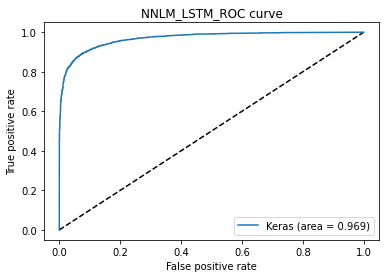

In [49]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.6189995
              precision    recall  f1-score   support

           0     0.9005    0.9213    0.9108      4154
           1     0.9174    0.8957    0.9064      4054

    accuracy                         0.9086      8208
   macro avg     0.9089    0.9085    0.9086      8208
weighted avg     0.9088    0.9086    0.9086      8208



In [51]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64,return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_9 (Reshape)         (None, 1, 128)            0         
                                                                 
 dropout_14 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_15 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                

In [52]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 123ms/step - loss: 0.1136 - accuracy: 0.9640 - val_loss: 0.2869 - val_accuracy: 0.9056
Epoch 2/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0622 - accuracy: 0.9767 - val_loss: 0.3750 - val_accuracy: 0.8986
Epoch 3/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0407 - accuracy: 0.9851 - val_loss: 0.4537 - val_accuracy: 0.8965
Epoch 4/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0301 - accuracy: 0.9889 - val_loss: 0.4968 - val_accuracy: 0.9013
Epoch 5/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0211 - accuracy: 0.9918 - val_loss: 0.5682 - val_accuracy: 0.8946
Epoch 6/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.6560 - val_accuracy: 0.8952
Epoch 00006: early stopping


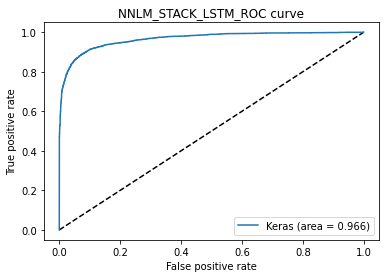

In [53]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_STACK_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [54]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.6059422
              precision    recall  f1-score   support

           0     0.8953    0.9266    0.9107      4154
           1     0.9220    0.8890    0.9052      4054

    accuracy                         0.9080      8208
   macro avg     0.9086    0.9078    0.9079      8208
weighted avg     0.9085    0.9080    0.9080      8208

